In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('C:/Users/msi/Downloads/stock price/NFLX.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [3]:
# Show the number of trading days
print("Total number of traiding days: ",data.shape[0])
print("Total number of fields: ",data.shape[1])

Total number of traiding days:  5044
Total number of fields:  7


In [4]:
# Check the Null and NA values
print("Null values:", data.isnull().values.sum())
print("NA values:", data.isna().values.any())

Null values: 0
NA values: False


In [5]:
# Create a new dataframe with only the Open column and convert it into a NumPy array
data = data['Open'].values

# Reshape the data
data = data.reshape(-1, 1) 


In [6]:
# Split the data into training and testing sets
dataset_train = np.array(data[:int(data.shape[0]*0.8)])
dataset_test = np.array(data[int(data.shape[0]*0.8):])

In [7]:
# Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))

dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

In [8]:
# Create the function that will help us to create the datasets
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0]) 
        y.append(df[i, 0]) 
    x = np.array(x) 
    y = np.array(y)
    return x,y

In [9]:
# Create the training and testing data by calling our function for each one
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

In [10]:
# Reshape the data to make it a 3D array in order to use it in LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [11]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1)) 

In [12]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_2 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

In [13]:
# Reshape the feature for the LSTM layer 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # for expecting 3 dimentions, not 2
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [26]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='Adadelta')

In [19]:
epochs = 10
batch_size = 64 

# Save the model and start the training
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
model.save('stock_prediction')

Epoch 1/10
63/63 [==============================] - 31s 336ms/step - loss: 3.4974e-04
Epoch 2/10
63/63 [==============================] - 19s 305ms/step - loss: 3.9651e-04
Epoch 3/10
63/63 [==============================] - 21s 341ms/step - loss: 4.0768e-04
Epoch 4/10
63/63 [==============================] - 21s 340ms/step - loss: 4.0612e-04
Epoch 5/10
63/63 [==============================] - 20s 322ms/step - loss: 3.9956e-04
Epoch 6/10
63/63 [==============================] - 21s 332ms/step - loss: 4.3052e-04
Epoch 7/10
63/63 [==============================] - 22s 348ms/step - loss: 4.0052e-04
Epoch 8/10
63/63 [==============================] - 21s 332ms/step - loss: 4.2667e-04
Epoch 9/10
63/63 [==============================] - 20s 323ms/step - loss: 3.8104e-04
Epoch 10/10
63/63 [==============================] - 22s 343ms/step - loss: 3.7347e-04


INFO:tensorflow:Assets written to: stock_prediction\assets


INFO:tensorflow:Assets written to: stock_prediction\assets


In [20]:
# Load the model
model = load_model('stock_prediction')

In [21]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)) 

30/30 [==============================] - 5s 88ms/step


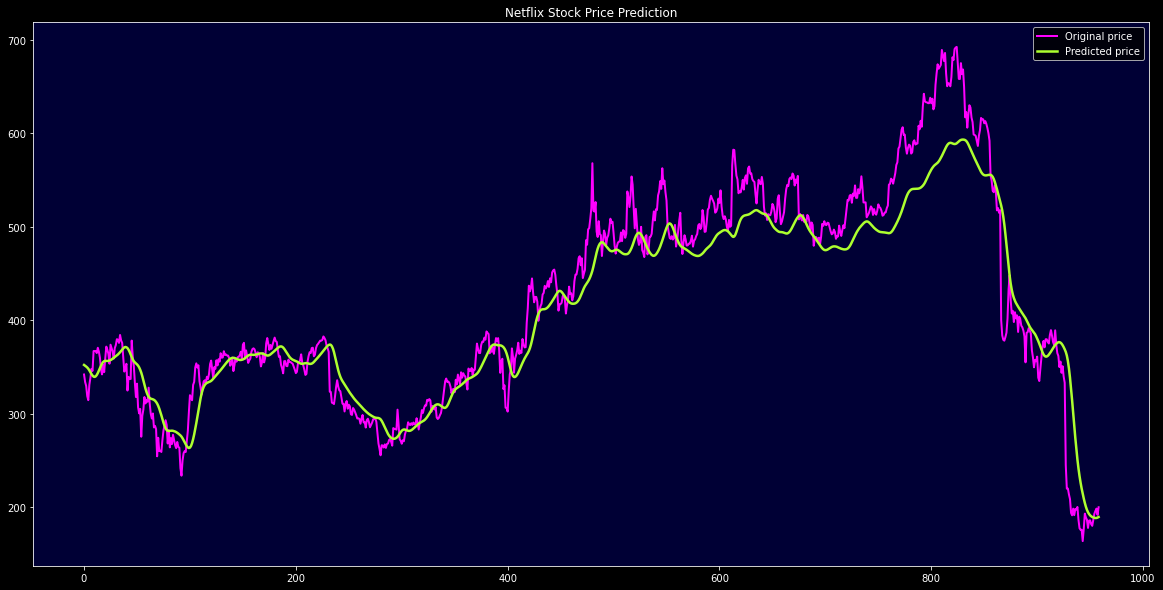

In [22]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor('#000035')
ax.plot(y_test_scaled, color='fuchsia', linewidth=2, label='Original price')
plt.plot(predictions, color='greenyellow', linewidth=2.5, label='Predicted price')
plt.title('Netflix Stock Price Prediction')
plt.legend(); 